# Titanic Project
The goal is to correctly predict if someone survived the Titanic shipwreck. At the end I created a web API to predict which passengers died or not.

**Best results : 83.7 % accuracy**

## Overview
### 1) Data Exploration and Cleaning

### 2) Feature Engineering

### 3) Data Preprocessing for Model

### 4) Basic Model Building

### 5) Model Tuning

### 6) Ensemble Model Building

### 7) Results

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# custom estimator
from custom_estimators import FeatureSelector, IsAlone, ExtractName

In [2]:
sns.set(style = 'ticks')
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 144

# Data Exploration and Cleaning

First we load the datasets.

In [3]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

## Observations and Assumptions

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Checking basic info on the datasets

In [5]:
train.shape, test.shape

((891, 12), (418, 11))

In [6]:
train.info(), print(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass 

(None, None, None)

Checking missing values.

In [7]:
train.isna().any(), print(), test.isna().any()

(PassengerId    False
 Survived       False
 Pclass         False
 Name           False
 Sex            False
 Age             True
 SibSp          False
 Parch          False
 Ticket         False
 Fare           False
 Cabin           True
 Embarked        True
 dtype: bool,
 None,
 PassengerId    False
 Pclass         False
 Name           False
 Sex            False
 Age             True
 SibSp          False
 Parch          False
 Ticket         False
 Fare            True
 Cabin           True
 Embarked       False
 dtype: bool)

**Variables with missing values:**
train: *Age, Cabin and Embarked*
test: *Age, Fare and Cabin*
Let us continue to find out more about missing values.

In [8]:
def count_na(df, columns):
    '''
    Count the missing values by column.

    Parameters:
        df: dataframe
        columns: columns of the dataframe
    Returns: Number of missing values by column
    '''

    counts = [(df[col].isna() == 1).sum() for col in columns]
    print([(columns[i], counts[i]) for i in range(len(columns))])


In [9]:
# Number of missing values in train_data
count_na(train, ['Age', 'Cabin', 'Embarked'])

#Number of missing values in test_data
count_na(test, ['Age', 'Cabin', 'Fare'])

[('Age', 177), ('Cabin', 687), ('Embarked', 2)]
[('Age', 86), ('Cabin', 327), ('Fare', 1)]


In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
train.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [12]:
train['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
whole_data = pd.concat([train,test])

%matplotlib inline
whole_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [14]:
train.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'train_test'],
      dtype='object')

In [15]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

## Data Exploration and cleaning
#### 1) We compare each feature with the survived column to see how it affected the survival of the passengers.

#### 2) First seperate the columns into categorical and numerical and look at them individually.

#### 3) Look at correlations in the data.

#### 4) For each column, look at the records in it that survived or not.

#### 1) We compare each feature with the survived column to see how it affected the survival of the passengers.
### Pclass vs. Survived

In [16]:
train[['Pclass', 'Survived']].groupby('Pclass').mean().sort_values(by='Survived', ascending = False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


Passengers in 1st class are more likely to survive by 62.9% more than others apparently. Always when you can buy first class tickets :).

### Fare vs. Survived

In [17]:
train.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: Fare, Length: 248, dtype: int64

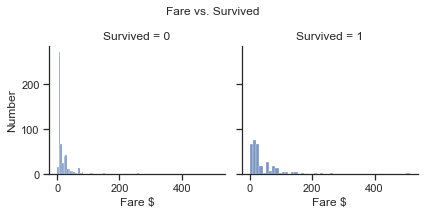

In [18]:
g = sns.FacetGrid(train, col = 'Survived')
g = g.map(sns.histplot, 'Fare', bins = 50, kde = False)
g.set_axis_labels('Fare $','Number')
g.fig.subplots_adjust(top = 0.8)
g.fig.suptitle("Fare vs. Survived")
plt.show()

### Sex vs. Survived

In [19]:
train[['Sex', 'Survived']].groupby('Sex').mean().sort_values('Survived', ascending = False)

,Survived
Sex,
female,0.742038
male,0.188908


Females have a higher chance of surviving than males.

In [20]:
### Age vs. Survived

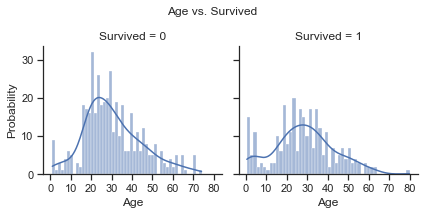

In [21]:
ticks = [i for i in np.arange(0, 90, 10)]
g = sns.FacetGrid(train, col = 'Survived')
g = g.map(sns.histplot, 'Age', bins = 50, kde= True)
g.set(xticks = ticks)
g.set_axis_labels('Age','Probability')
g.fig.subplots_adjust(top = 0.8)
g.fig.suptitle("Age vs. Survived")
plt.show()

From 0-10 years, passengers mostly survived.
From 20 - 40 years, passengers mostly died.
At 75+ years, it seems like all of them survived. We will keep 'Age' in the model.

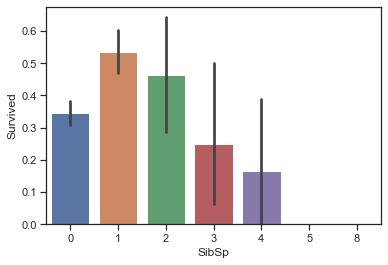

In [22]:
sns.barplot(x = train['SibSp'], y = train['Survived'])
plt.show()

It seems like the more you had siblings or spouses, the lesser chances to survive you had excluding 0 sibsp which is a little lower. Anyway let's continue.

### Parch vs. Survived

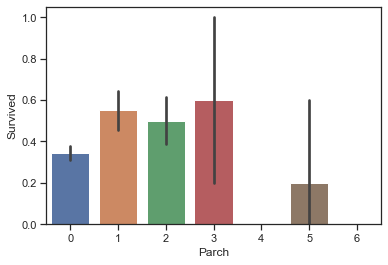

In [23]:
sns.barplot(x = train['Parch'], y = train['Survived'])
plt.show()

It seems like travelling alone wasn't recommended either because those with parch = 0 and sibsp = 0 have low survival rates.

### Embarked vs. Survived

In [24]:
train[['Embarked', 'Survived']].groupby('Embarked').mean().sort_values(by = 'Survived', ascending = False)

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


Cherbourg passengers survived at a better rate than the rest.

### Sex, Pclass, Embarked vs. Survived

C:\Users\kamga\PycharmProjects\scientificProject\venv\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\kamga\PycharmProjects\scientificProject\venv\lib\site-packages\seaborn\axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


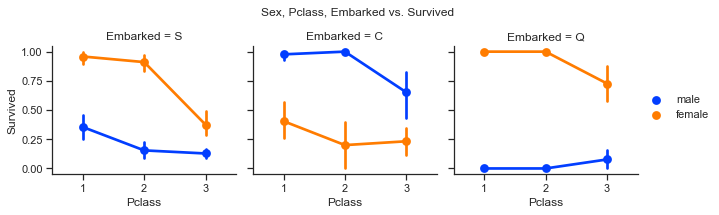

In [25]:
g = sns.FacetGrid(train, col = 'Embarked')
g.map(sns.pointplot,'Pclass' ,'Survived', 'Sex', palette = 'bright')
g.fig.subplots_adjust(top = 0.8)
g.fig.suptitle("Sex, Pclass, Embarked vs. Survived")
g.add_legend()
plt.show()

644 passengers embarked at S(most of them) so in average males have a lower survival rate than females.

### Age, Pclass vs. Survived

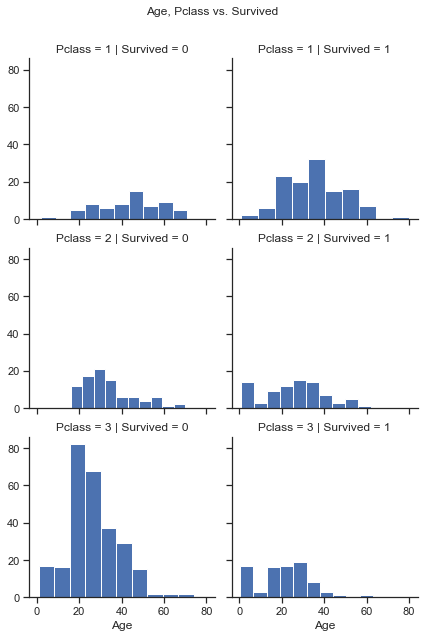

In [26]:
g = sns.FacetGrid(train, row = 'Pclass', col = 'Survived')
g.map(plt.hist, 'Age')
g.fig.subplots_adjust(top = 0.9)
g.fig.suptitle("Age, Pclass vs. Survived")
plt.show()

The 3rd class has the highest casualties

### Heatmap

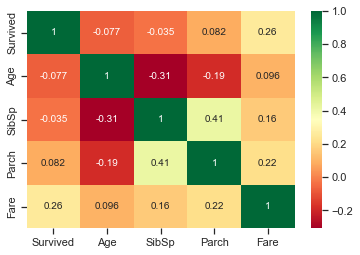

In [27]:
sns.heatmap(train[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']].corr(), annot=True, cmap='RdYlGn')
plt.show()

Since SipSp and Parch seem to be somewhat correlated, we remove them to reduce the noise in our model.

### Name

We extract each passenger's title

In [28]:
title = [i.split(",")[1].split(".")[0].strip() for i in train["Name"]]
title = Counter(title)
title

Counter({'Mr': 517,
         'Mrs': 125,
         'Miss': 182,
         'Master': 40,
         'Don': 1,
         'Rev': 6,
         'Dr': 7,
         'Mme': 1,
         'Ms': 1,
         'Major': 2,
         'Lady': 1,
         'Sir': 1,
         'Mlle': 2,
         'Col': 2,
         'Capt': 1,
         'the Countess': 1,
         'Jonkheer': 1})

Let's categorize it as follows:
* Mr/Master: 0
* Mrs/Miss: 1
* Others: 2

**Here is what we are going to do for the feature engineering.**

1. Drop out
    PassengerId(irrelevant),
    Name(feature engineered),
    Ticket(irrelevant) and
    Cabin(irrelevant and too many NaNs).
2. Create a new feature 'IsAlone'( = SibSp + Parch + 1) to indicate if a passenger is alone.
3. Extract titles from Name.
4. Missing value imputation and normalization for numerical features.
5. Encode the categorical features.

# Feature Engineering

**All feature transformers are done in custom_estimators.py.**

# Modeling

## Creating the pipeline

In [29]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
train_test       0
dtype: int64

In [30]:
# 'Embarked' has only two missing values
train['Embarked'].fillna(value = train['Embarked'].value_counts().index[0], inplace=True)
X = train.drop('Survived', axis = 1)
y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [31]:
num_columns = ['Age', 'Fare']
cat_columns = ['Pclass', 'Sex', 'Embarked', 'IsAlone', 'Title'] # We will create the features 'IsAlone' and 'Title'

In [32]:
num_pipe = Pipeline([('num_selector', FeatureSelector(num_columns)),
                     ('imputer', SimpleImputer(strategy = 'median')),
                     ('Normalization', StandardScaler())])

In [33]:
cat_pipe = Pipeline([('cat_selector', FeatureSelector(cat_columns)),
                     ('ohe', OneHotEncoder(sparse = False))])

In [34]:
union = FeatureUnion([('num', num_pipe),
                      ('cat', cat_pipe)])

In [35]:
learning_curve_pipe = Pipeline([('IsAlone', IsAlone("SibSp", "Parch", 'IsAlone')),
                                ('Title', ExtractName('Title')),
                                ('union', union)])

## Plotting the learning curve

Here we select a couple of classifiers to see the learning curves.

In [36]:
learning_curve_pipe = Pipeline([('IsAlone', IsAlone("SibSp", "Parch", 'IsAlone')),
                                ('Title', ExtractName('Title')),
                                ('union', union)])

In [37]:
X_curve = learning_curve_pipe.fit_transform(X)

In [38]:
def plot_learning_curve(clf, title, X, y):
    '''
    Plot the test and training learning curve.

    Parameters:
        clf: estimator
        title: graph title
    Returns:
        Learning curve
    '''

    train_sizes,train_scores,test_scores = learning_curve(clf,X,y,random_state = 42,cv = 20, shuffle = True)

    plt.figure()


    ylim = (0.7, 1.01)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.1,
                color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
        label="Training score | Avg: {}".format(str(round(train_scores_mean.mean(), 2))))
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
        label="Cross-validation score | Avg: {}".format(str(round(test_scores_mean.mean(), 2))))


    plt.title(title)

    plt.legend(loc="best")
    plt.show()

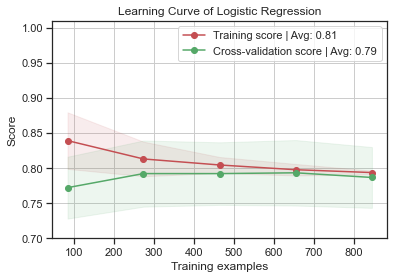

In [39]:
plot_learning_curve(LogisticRegression(solver = 'lbfgs'),'Learning Curve of Logistic Regression', X_curve, y)

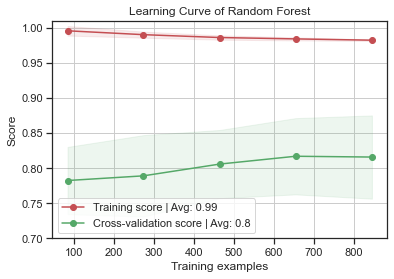

In [40]:
plot_learning_curve(RandomForestClassifier(n_estimators = 100),'Learning Curve of Random Forest', X_curve, y)

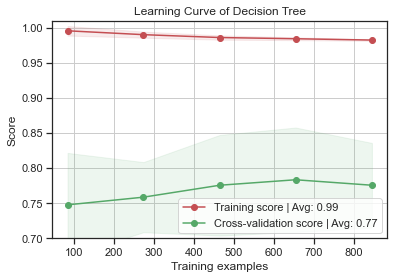

In [41]:
plot_learning_curve(DecisionTreeClassifier(),'Learning Curve of Decision Tree', X_curve, y)

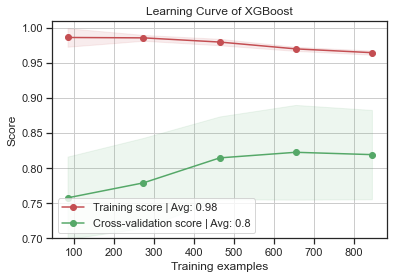

In [42]:
plot_learning_curve(xgb.XGBClassifier(),'Learning Curve of XGBoost', X_curve, y)

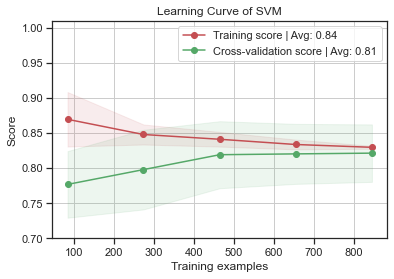

In [43]:
plot_learning_curve(SVC(gamma = 'scale'),'Learning Curve of SVM', X_curve, y)

* Random forest, decision tree and xgboost seem to be overfitting.
This leaves us with
* logistic regression and
* svm. SVM seems to have a greater average score so we will use it.

## Tuning the Hyperparameters

Here we  tune hyperparameters for SVM.

In [ ]:
clf = SVC(probability=True)

pipe = Pipeline([('IsAlone', IsAlone("SibSp", "Parch", 'IsAlone')),
                 ('Title', ExtractName('Title')),
                 ('union', union),
                 ('classifier', clf)])

param_grid  = [{'classifier__kernel': ['rbf'], 'classifier__gamma': [.1,.5,1,2,5,10],
                                  'classifier__C': [.1, 1, 10, 100, 1000]},
                                 {'classifier__kernel': ['linear'], 'classifier__C': [.1, 1, 10, 100, 1000]},
                                 {'classifier__kernel': ['poly'], 'classifier__degree' : [2,3,4,5], 'classifier__C': [.1, 1, 10, 100, 1000]}]
Removed some elements because it took too long to process.

In [ ]:
param_grid  = [{'classifier__kernel': ['rbf'], 'classifier__gamma': [.1,.5,1,2,5,10],
                                  'classifier__C': [.1, 1, 10, 100, 1000]},
                                 {'classifier__kernel': ['linear'], 'classifier__C': [.1, 1, 10, 100, 1000]},
                                 {'classifier__kernel': ['poly'], 'classifier__degree' : [2,3,4,5], 'classifier__C': [.1, 1, 10, 100, 1000]}]

grid_search = GridSearchCV(pipe, param_grid, cv = 2, scoring = 'accuracy', n_jobs = None, verbose = 1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# training score and CV score
result = "{} is {}"
print(result.format("Training score", grid_search.score(X_train, y_train)))
print(result.format("CV score", grid_search.best_score_))
print(result.format("Best parameter", grid_search.best_params_))

In [ ]:
param_grid  = [{'classifier__kernel': ['rbf'], 'classifier__gamma': [.1,.5,1,2,5,10],
                                  'classifier__C': [.1, 1, 10, 100, 1000]},
                                 {'classifier__kernel': ['linear'], 'classifier__C': [.1, 1, 10, 100, 1000]},
                                 {'classifier__kernel': ['poly'], 'classifier__degree' : [2,3,4,5], 'classifier__C': [.1, 1, 10, 100, 1000]}]

grid_search = GridSearchCV(pipe, param_grid, cv = 2, scoring = 'accuracy', n_jobs = None, verbose = 1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# training score and CV score
result = "{} is {}"
print(result.format("Training score", grid_search.score(X_train, y_train)))
print(result.format("CV score", grid_search.best_score_))
print(result.format("Best parameter", grid_search.best_params_))

In [ ]:
# Accuracy, AUC and F1
y_prediction = best_model.predict(X_test)
pred_proba = best_model.predict_proba(X_test)[:, 1]

print("=" * 100)
print(result.format("Accuracy", accuracy_score(y_test, y_prediction)))
print(result.format("AUC", roc_auc_score(y_test, pred_proba)))
print(result.format("F1 score", f1_score(y_test, y_prediction)))



In [47]:
# Accuracy, AUC and F1
y_prediction = best_model.predict(X_test)
pred_proba = best_model.predict_proba(X_test)[:, 1]

print("=" * 100)
print(result.format("Accuracy", accuracy_score(y_test, y_prediction)))
print(result.format("AUC", roc_auc_score(y_test, pred_proba)))
print(result.format("F1 score", f1_score(y_test, y_prediction)))



AttributeError: predict_proba is not available when  probability=False

In [ ]:
# Feature importance
feature_importance = best_model.steps[3][1].feature_importances_
num_cols = best_model.named_steps['union'].transformer_list[0][1].steps[0][1].columns.copy()
cat_cols = best_model.named_steps['union'].transformer_list[1][1].steps[1][1].get_feature_names().copy()
num_cols.extend(cat_cols)
df = pd.DataFrame({'Feature': num_cols, 'Feature Importance': feature_importance}).sort_values("Feature Importance", ascending = False)
df

# Submission

In [ ]:
# Prep the submission
y_pred = pd.Series(best_model.predict(test), name = 'Survived')
predict = pd.DataFrame({'PassengerId': test['PassengerId'],
                       "Survived": y_pred})

In [ ]:
predict

# Model Deployment

We will now:
* Build a web app using our model and Flask.
* Then deploy it to Heroku(a cloud platform).
* On the web app, you can enter the characteristics of a person on the titanic and then get the chances that person survived.